In [1]:
import json
import yaml
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor

from g2p_en import g2p as grapheme_to_phonem

from IPython.display import (
    Audio, display, clear_output)


In [2]:
#processor = AutoProcessor.from_pretrained("tensorspeech/tts-fastspeech2-ljspeech-en")
processor = AutoProcessor.from_pretrained('../dump_libritts/libritts_mapper.json') #("../tensorflow_tts/processor/pretrained/libritts_mapper.json")
g2p = grapheme_to_phonem.G2p()


In [17]:
processor.speakers_map


{'4406': 0,
 'fajb': 1,
 '2289': 2,
 'fahe': 3,
 '831': 4,
 '5022': 5,
 '7511': 6,
 '7059': 7,
 'fadf': 8,
 'mcll': 9,
 '3240': 10,
 '3982': 11,
 '8630': 12,
 'fcks': 13,
 '196': 14,
 'fmbb': 15,
 '4680': 16,
 'fslw': 17,
 'mdaw': 18,
 'fahj': 19,
 'fser': 20,
 '4397': 21,
 'fmra': 22,
 'fjcs': 23,
 '7800': 24,
 'fsaa': 25,
 'mglp': 26,
 '6385': 27,
 '8838': 28,
 'fsqh': 29,
 '1088': 30,
 '5867': 31,
 'fnxs': 32,
 'fejm': 33,
 '4267': 34,
 '8088': 35,
 '3830': 36,
 '7178': 37,
 'fkep': 38,
 '2843': 39,
 '4297': 40,
 '78': 41,
 '1970': 42,
 '4137': 43,
 '3526': 44,
 '669': 45,
 '8123': 46,
 '6019': 47,
 'fclm': 48,
 '1098': 49,
 'ftdd': 50,
 'mjwm': 51,
 'fjdk': 52,
 'mash': 53,
 'mjcm': 54,
 'mmxh': 55,
 'mdpj': 56,
 '1502': 57,
 '83': 58,
 '1116': 59,
 '8324': 60,
 'flbb': 61,
 'mmbg': 62,
 '7190': 63,
 '5393': 64,
 '8468': 65,
 'fcmm': 66,
 '4362': 67,
 '3486': 68,
 '6078': 69,
 '1743': 70,
 '4051': 71,
 'fssb': 72,
 '5163': 73,
 'fsrg': 74,
 'fkmn': 75,
 'fsjs': 76,
 '7367': 77,
 '4

In [4]:

input_ids = processor.symbols_to_ids(processor.clean_g2p(g2p("i love you")))

# input_ids = processor.text_to_sequence(input_text)

In [5]:
# fastspeech2 = TFAutoModel.from_pretrained("../ttsexamples/fastspeech2_libritts/outdir_libri/checkpoints/model-100000.h5")

config_path = "../ttsexamples/fastspeech2_libritts/conf/fastspeech2libritts.yaml"
# model_path = "../ttsexamples/fastspeech2_libritts/outdir_libri/checkpoints/model-100000.h5"

# model_path = "../ttsexamples/fastspeech2_libritts/outdir_libri/checkpoints/model-20000.h5"
model_path = "../ttsexamples/fastspeech2_libritts/output_libri_test_with_kids/checkpoints/model-150000.h5"
config = AutoConfig.from_pretrained(pretrained_path=config_path)
fastspeech2 = TFAutoModel.from_pretrained(
    pretrained_path=model_path,
    config=config)


In [6]:
mb_melgan = TFAutoModel.from_pretrained("tensorspeech/tts-mb_melgan-ljspeech-en")


# Save to Pb

In [6]:
# save model into pb and do inference. Note that signatures should be a tf.function with input_signatures.
tf.saved_model.save(fastspeech2, "./test_saved", signatures=fastspeech2.inference)
tf.saved_model.save(mb_melgan, "./mb_melgan", signatures=mb_melgan.inference)

INFO:tensorflow:Assets written to: ./test_saved/assets


INFO:tensorflow:Assets written to: ./test_saved/assets


INFO:tensorflow:Assets written to: ./mb_melgan/assets


INFO:tensorflow:Assets written to: ./mb_melgan/assets


# Load and Inference

In [7]:
fastspeech2 = tf.saved_model.load("./test_saved")

In [7]:
input_text = "Cats and boots are Ariel's favorite song but what is yours"
# input_ids = processor.text_to_sequence(g2p(input_text))

input_ids = processor.symbols_to_ids(processor.clean_g2p(g2p(input_text)))


In [18]:
# 24? 37 83 94, 110 148
mel_before, mel_after, duration_outputs, _, _ = fastspeech2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    speaker_ids=tf.convert_to_tensor([32], dtype=tf.int32), #59, 101,
#     speaker_ids=tf.convert_to_tensor(list(range(173)), dtype=tf.int32), #59, 101,
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
    energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32)
)

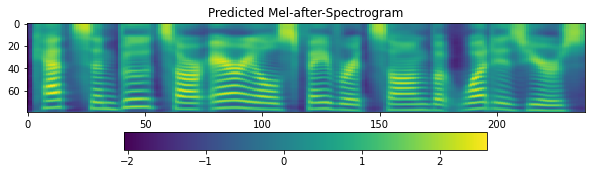

In [19]:
mel_after = tf.reshape(mel_after, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_after), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()

In [20]:
audios = mb_melgan.inference(mel_after[None, ...])
Audio(audios[0, :, 0], rate=24000, autoplay=True)

# Let inference other input to check dynamic shape

In [ ]:
input_text = "The Commission further recommends that the Secret Service coordinate its planning as closely as possible with all of the Federal agencies from which it receives information."
input_ids = processor.text_to_sequence(input_text)

In [ ]:
mel_before, mel_after, duration_outputs, _, _ = fastspeech2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
    energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32)
)

In [ ]:
mel_after = tf.reshape(mel_after, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_after), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()

In [ ]:
mb_melgan = TFAutoModel.from_pretrained("tensorspeech/tts-mb_melgan-ljspeech-en")
tf.saved_model.save(mb_melgan, "./mb_melgan", signatures=mb_melgan.inference)

In [ ]:
mb_melgan = tf.saved_model.load("./mb_melgan")
mels = np.load("../dump_ljspeech/valid/norm-feats/LJ001-0009-norm-feats.npy")
audios = mb_melgan.inference(mels[None, ...])
plt.plot(audios[0, :, 0])

In [ ]:
Audio(audios[0, :, 0], rate=24000, autoplay=True)

# load local
from [here](https://github.com/dathudeptrai/TensorFlowTTS/blob/master/notebooks/multiband_melgan_inference.ipynb)

In [ ]:
# initialize fastspeech model.
from pathlib import Path
Path('../pretrained/fastspeech2.v1/conf/fastspeech2.v1.yaml')

fs_config = AutoConfig.from_pretrained('../pretrained/fastspeech2.v1/conf/fastspeech2.v1.yaml')
fastspeech = TFAutoModel.from_pretrained(
    config=fs_config,
    pretrained_path="../pretrained/fastspeech2.v1/checkpoints/model-150000.h5"
)



In [ ]:
# initialize melgan model
config = AutoConfig.from_pretrained("../pretrained/mbvocs24k/multiband_melgan.v1_24k.yaml")
mb_melgan = TFAutoModel.from_pretrained(
    config=config, 
    pretrained_path='../pretrained/mbvocs24k/libritts_24k.h5', # "../examples/fastspeech2/checkpoints/model-150000.h5",
    name="melgan"
)

In [ ]:
# fake_mels = tf.random.uniform(shape=[4, 256, 80], dtype=tf.float32)
# audios = mb_melgan.inference(fake_mels)
mels = np.load("../dump_ljspeech/valid/norm-feats/LJ001-0009-norm-feats.npy")
audios = mb_melgan.inference(mels[None, ...])
Audio(audios[0, :, 0], rate=24000, autoplay=True)

In [ ]:
# inference
processor = AutoProcessor.from_pretrained(pretrained_path="../dump_ljspeech/ljspeech_mapper.json")
ids = processor.text_to_sequence("Recent research at Harvard has shown meditating for as little as 8 weeks, can actually increase the grey matter in the parts of the brain responsible for emotional regulation, and learning.")
ids = tf.expand_dims(ids, 0)


In [ ]:
input_ids = processor.text_to_sequence("Cats and boots")
# input_ids = tf.expand_dims(ids, 0)


In [ ]:
# masked_mel_before, masked_mel_after, duration_outputs = fastspeech.inference(
#     ids,
#     speaker_ids=tf.zeros(shape=[tf.shape(ids)[0]], dtype=tf.int32),
#     speed_ratios=tf.constant([1.0], dtype=tf.float32)
# )
mel_before, mel_after, duration_outputs, _, _ = fastspeech2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
    energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32)
)

In [ ]:
mel_after = tf.reshape(mel_after, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_after), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()


In [ ]:
audios = mb_melgan.inference(mel_after[None, ...])
Audio(audios[0, :, 0], rate=24000, autoplay=True)